# Contexto

El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.
- **date**: fecha y hora.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerías

In [271]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from haversine import haversine
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

import holidays
from haversine import haversine
from pandas import DataFrame

# Carga del dataset



In [272]:
# Carga de datos del dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)


# Análisis exploratorio de datos

## Análisis descriptivo

In [273]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [274]:
# Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

-Variables numéricas: fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, droptoff_latitude, passenger_count.

-Variables categóricas: key, date, pickup_datetime, passenger_count.

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [276]:
# Valores nulos
df.isna().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

## Análisis de datos atípicos

Para comenzar, quitamos los renglones en donde los valores de la columna objetivo sea nula o menor a 0

In [278]:
df = df[df["fare_amount"].notna()]
df = df[df["fare_amount"].astype(float) > 0]

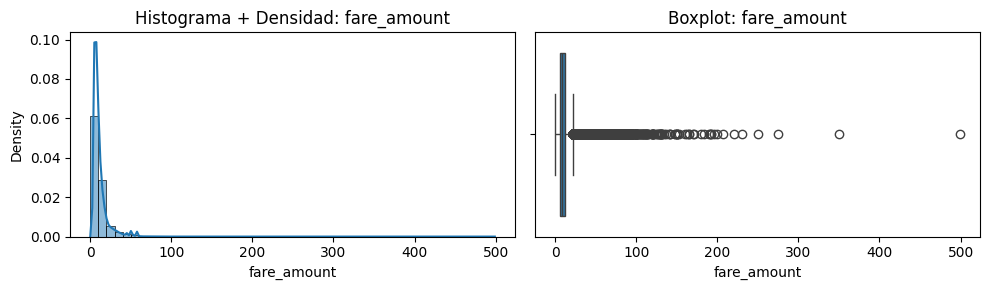

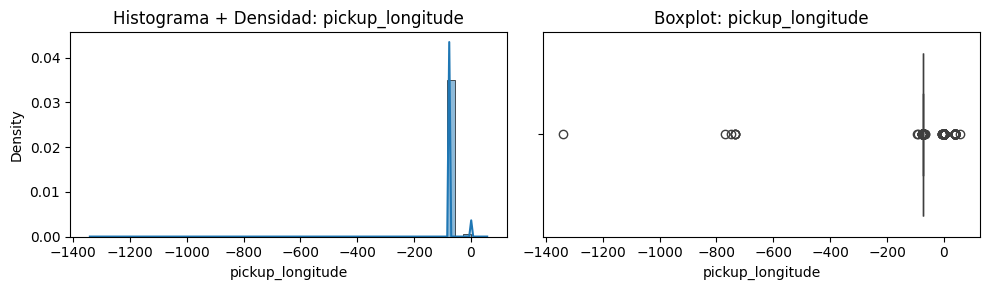

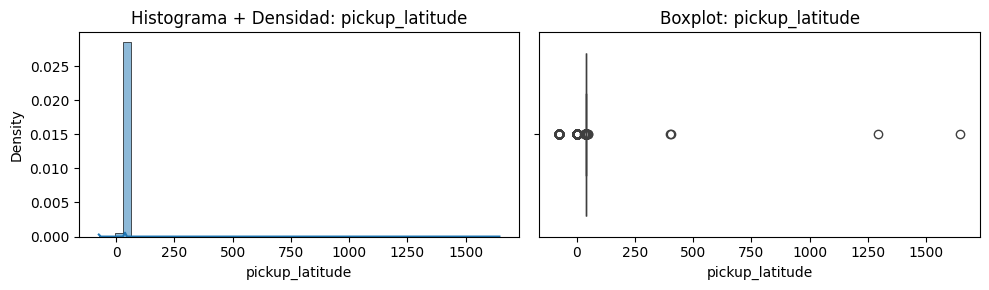

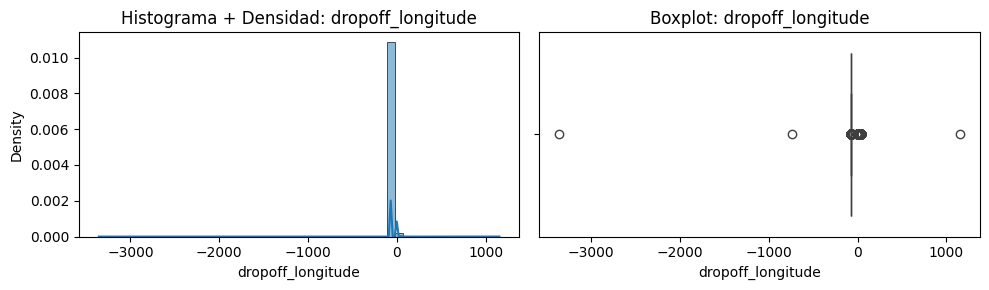

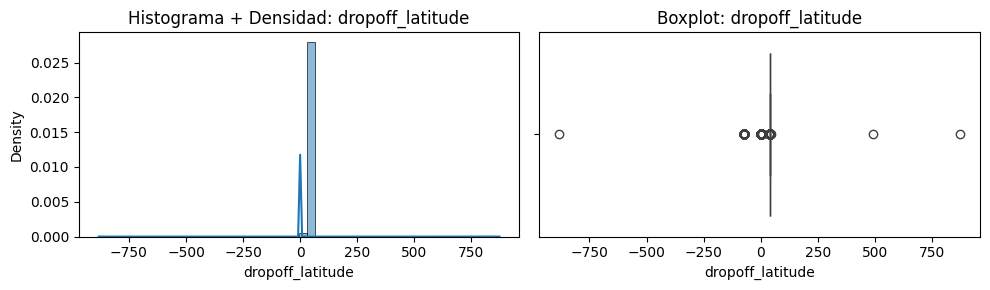

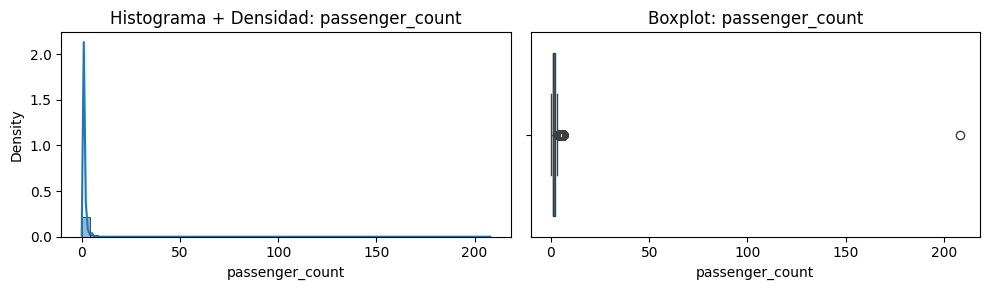

In [279]:
# Histogramas + densidad y boxplots
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('key')

def densityHistBoxPlot(df: DataFrame, cols: list):
    for c in cols:
        plt.figure(figsize=(10,3))
        
        # Histograma + densidad
        plt.subplot(1,2,1)
        sns.histplot(df[c].dropna(), bins=50, kde=True, stat="density")
        plt.title(f"Histograma + Densidad: {c}")
        
        # Boxplot
        plt.subplot(1,2,2)
        sns.boxplot(x=df[c].dropna())
        plt.title(f"Boxplot: {c}")
        
        plt.tight_layout()
        plt.show()

densityHistBoxPlot(df, num_cols)

En las gráficas podemos encontrar que hay valores atípicos sin sentido, como un Uber con más de 200 pasajeros o latitudes y longitudes que exceden los límites 

In [280]:
def scatterPloteinador(df: DataFrame):
    # Obtener columnas numéricas (excluyendo 'key' que ya fue eliminada)
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    if 'key' in num_cols: num_cols.remove('key')
    num_cols.remove('fare_amount')

    # Scatterplots contra fare_amount
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        plt.scatter(df[col], df['fare_amount'], alpha=0.5)
        plt.title(f'{col} vs fare_amount')
        plt.xlabel(col)
        plt.ylabel('fare_amount')
        plt.grid(True)
        plt.show()

## Codificación de variables categóricas

Divimos los casos de la cuenta de pasajeros según lo considerábamos un delivery, un servicio normal o uno premium, utilizando variables dummies para la misma

In [281]:
# Cantidad de pasajeros/as
df.loc[(df['passenger_count'] < 0), 'passenger_count'] = 0
df.loc[(df['passenger_count'] > 6), 'passenger_count'] = 6

# Crear categorías para cantidad de pasajeros
def categorize_passengers(count):
    if count == 0:
        return 'delivery'
    elif 1 <= count <= 4:
        return 'normal'
    elif 5 <= count <= 6:
        return 'xl'

df['passenger_category'] = df['passenger_count'].apply(categorize_passengers)

# Crear dummies para las categorías
passenger_dummies = pd.get_dummies(df['passenger_category'], prefix='passenger', dtype=int, drop_first=True)
df = pd.concat([df, passenger_dummies], axis=1)

# Dropear columnas que no serán utilizadas
df.drop(columns=['passenger_category','passenger_count'], inplace=True)

Se transforma la columna de fechas en componentes útiles (hora, día, semana, mes), generando variables binarias para franjas horarias y estaciones. Además, se codifican días de semana y semanas en el año con funciones seno/coseno y se marca fines de semana/feriados. Finalmente, se eliminan columnas intermedias innecesarias.

In [282]:
# Separar datetime en date y time
df["dateTime"] = pd.to_datetime(df["pickup_datetime"]) # sin errors, ya que checkeamos que no hay valores nulos
df["dateTime"] = df["dateTime"].dt.tz_convert("America/New_York") # Esto cubre el horario de verano

df["time"] = df["dateTime"].dt.hour
df["date"] = df["dateTime"].dt.date

# 1 a 7 ==> madrugada ==> V = 1  ==> CODIFICACIÓN BINARIA ==> 0 | 0
# 7 a 11 ==> mañana ==> V = 2 ==> CODIFICACIÓN BINARIA ==> 0 | 1
# 11 a 19 ==> tarde ==> V = 3 ==> CODIFICACIÓN BINARIA ==> 1 | 1
# 19 a 1 ==> noche ==> V = 4 ==> CODIFICACIÓN BINARIA ==> 1 | 0

df["bin_time_1"] = 0
df["bin_time_2"] = 0

df.loc[(df["time"] >= 7) & (df["time"] < 11), ["bin_time_1", "bin_time_2"]] = [0, 1]
df.loc[(df["time"] >= 11) & (df["time"] < 19), ["bin_time_1", "bin_time_2"]] = [1, 1]
df.loc[(df["time"] >= 19) | (df["time"] < 1), ["bin_time_1", "bin_time_2"]] = [1, 0]

# Codificación de ...
df["date"] = pd.to_datetime(df["date"])
df["weekday_num"] = df["date"].dt.dayofweek + 1

k = (2*math.pi)/7 # 7 por los días de la semana

df["sen_weekday_num"] = np.sin(k*df["weekday_num"])
df["cos_weekday_num"] = np.cos(k*df["weekday_num"])

k_week= 2*np.pi/52

df["week"] = df["date"].dt.isocalendar().week

df["sen_week_num"] = np.sin(k_week*df["week"])
df["cos_week_num"] = np.cos(k_week*df["week"])

# Traer feriados para validar si es fin de semana o feriado
us_holidays = holidays.US(state="NY")

df["weekend_or_holiday"] = ((df["weekday_num"] >= 6) | (df["date"].dt.date.isin(us_holidays))).astype(int)

# INVIERNO: de diciembre a febrero ==> CODIFICACIÓN BINARIA ==> 0 | 0
# PRIMAVERA: de marzo a mayo ==> CODIFICACIÓN BINARIA ==> 0 | 1
# VERANO: de junio a agosto ==> CODIFICACIÓN BINARIA ==> 1 | 1
# OTOÑO: de septiembre a noviembre ==> CODIFICACIÓN BINARIA ==> 1 | 0

df['month'] = df['date'].dt.month

df["bin_month_1"] = 0
df["bin_month_2"] = 0

df.loc[(df['month'] >= 3) & (df['month'] < 6), ["bin_month_1", "bin_month_2"]] = [0, 1]
df.loc[(df['month'] >= 6) & (df['month'] < 9), ["bin_month_1", "bin_month_2"]] = [1, 1]
df.loc[(df['month'] >= 9) & (df['month'] < 12), ["bin_month_1", "bin_month_2"]] = [1, 0]
df.loc[(df['month'] == 12) | (df['month'] < 3), ["bin_month_1", "bin_month_2"]] = [0, 0]

df.drop(columns=['dateTime', 'date', 'time', 'weekday_num','key', 'week', 'month', 'pickup_datetime'], inplace=True)

## Región geográfica de estudio - Imputación de la longitud y latitud

Según el NYC Department of City Planning, los límites de la ciudad se encuentran en:
- West −74.257159° 
- East −73.699215° 
- North 40.915568° 
- South 40.496010°

Nosotros redondeamos un poco estos valores para poder delimitar correctamente la ciudad.

- longitud ==> este/oeste
- latitud ==> norte/sur

In [283]:
# Setear coordenadas inválidas a NaN
df.loc[df["pickup_latitude"] > 41, ["pickup_latitude"]] = np.nan
df.loc[df["pickup_latitude"] < 40, ["pickup_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] > 41, ["dropoff_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] < 40, ["dropoff_latitude"]] = np.nan

df.loc[df["pickup_longitude"] > -73.50, ["pickup_longitude"]] = np.nan
df.loc[df["pickup_longitude"] < -74, ["pickup_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] > -73.50, ["dropoff_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] < -74, ["dropoff_longitude"]] = np.nan


Realizamos un filtro para eliminar los valores donde el punto de partida y salida es el mismo (es decir, la distancia recorrida es igual a 0), escalamos las variables y luego imputamos los valores faltantes o nulos con KNN. Finalmente, calculamos la distancia con la librería _haversine_.

In [284]:
mask = (abs(df["dropoff_longitude"] - df["pickup_longitude"]) < 0.001) & (abs(df["dropoff_latitude"] - df["pickup_latitude"]) < 0.001)

df.loc[mask, ["dropoff_longitude", "dropoff_latitude"]] = np.nan

## Escalado y spliteo

In [285]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

In [286]:
train_df, test_df= train_test_split(df_scaled, test_size=0.2, random_state=0)

print(train_df.shape)
print(test_df.shape)


cols_to_impute=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

imputer = KNNImputer(n_neighbors=10)
imputer.fit(train_df[cols_to_impute])

train_df_imputed = train_df.copy()
test_df_imputed = test_df.copy()

train_df_imputed[cols_to_impute] = imputer.transform(train_df_imputed[cols_to_impute])
test_df_imputed[cols_to_impute] = imputer.transform(test_df_imputed[cols_to_impute])

print(train_df_imputed.shape)
print(test_df_imputed.shape)

(159982, 16)
(39996, 16)
(159982, 16)
(39996, 16)


Una vez que obtuvimos la posición del inicio y el final del recorrido, obtenemos la distancia en km.

In [287]:

train_df_imputed['distance_km'] = train_df_imputed.apply(
    lambda row: haversine(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ),
    axis=1
)

test_df_imputed['distance_km'] = test_df_imputed.apply(
    lambda row: haversine(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ),
    axis=1
)

train_df_imputed = train_df_imputed.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1)
test_df_imputed = test_df_imputed.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1)

In [288]:
x_train = train_df_imputed.drop(['fare_amount'], axis = 1).copy()
y_train = train_df_imputed[['fare_amount']].copy()

x_test = test_df_imputed.drop(['fare_amount'], axis = 1).copy()
y_test = test_df_imputed[['fare_amount']].copy()


In [289]:
x_train.columns

Index(['passenger_normal', 'passenger_xl', 'bin_time_1', 'bin_time_2',
       'sen_weekday_num', 'cos_weekday_num', 'sen_week_num', 'cos_week_num',
       'weekend_or_holiday', 'bin_month_1', 'bin_month_2', 'distance_km'],
      dtype='object')

Una vez obtenidas las variables que se van a utilizar en la regresión lineal, realizamos la matriz de correlación de los datos, junto con el histograma y boxplot de la distancia en km.

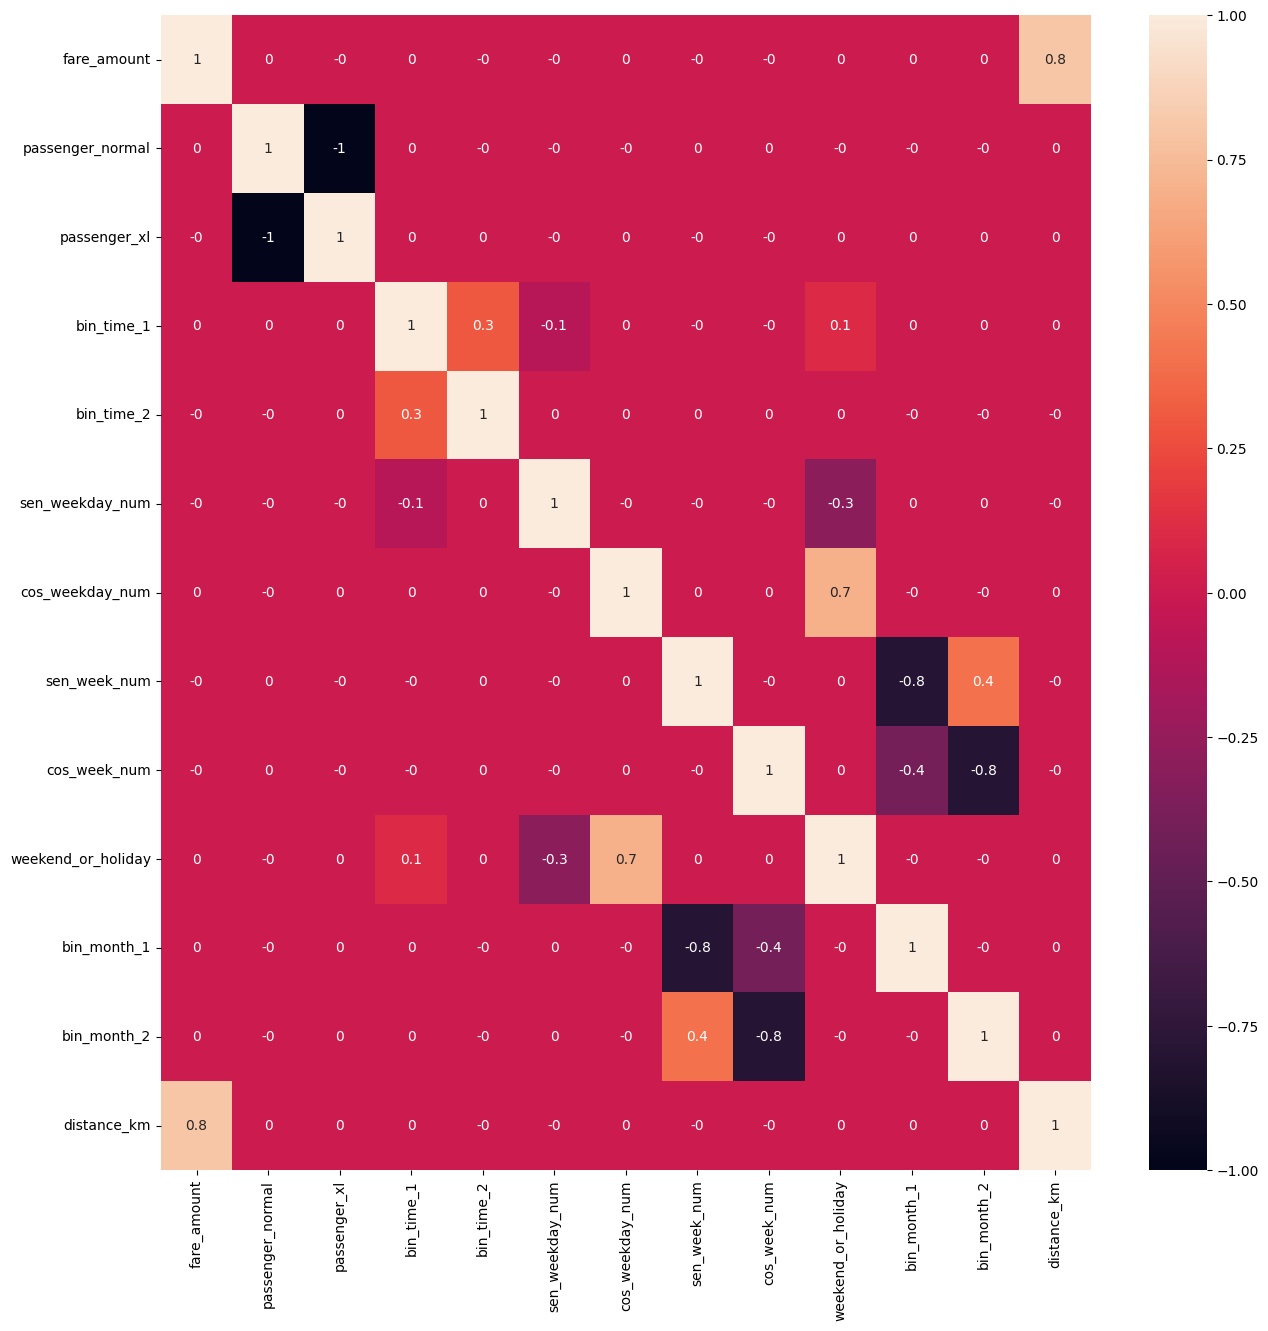

In [290]:
corr = train_df_imputed.corr().round(1)
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, cmap='rocket', center=0)
plt.show()

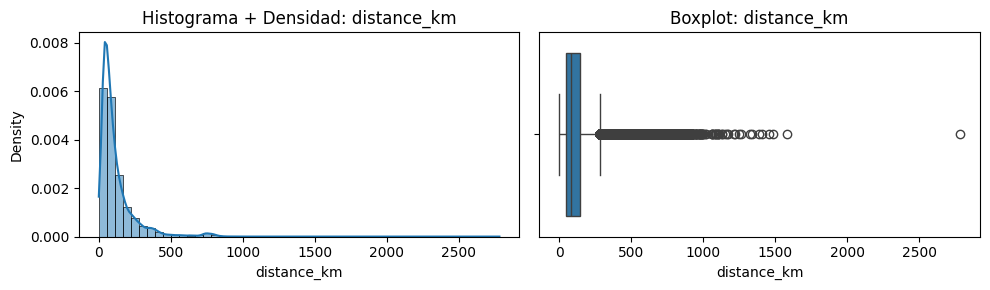

In [291]:
densityHistBoxPlot(train_df_imputed, ["distance_km"])


## Regresión lineal

In [292]:

linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_test)

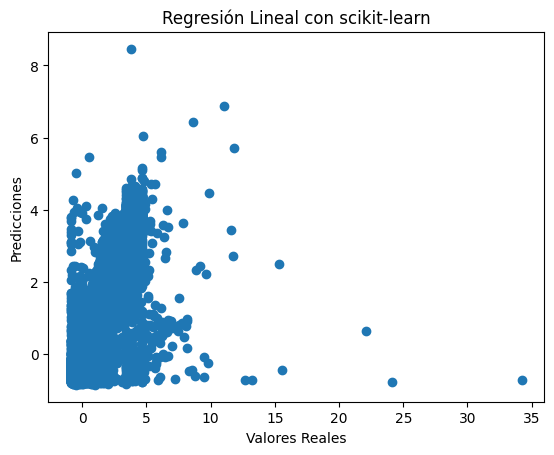

In [293]:
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Regresión Lineal con scikit-learn")
plt.show()

In [294]:
# Métricas del modelo
mse_selfeat = mean_squared_error(y_test, y_pred)
r2_selfeat = r2_score(y_test, y_pred)
score_selfeat = linear_model.score(x_test, y_test)
score_selfeat_train = linear_model.score(x_train, y_train)
print(f"Puntaje train: {score_selfeat_train}")
print(f"Puntaje test: {score_selfeat}")

print(f'Error cuadrático medio (MSE) con features seleccionadas: {mse_selfeat:.2f}')
print(f'Coeficiente de determinación (R^2) con features seleccionadas: {r2_selfeat:.2f}\n')

Puntaje train: 0.6248918941833295
Puntaje test: 0.6172002938115204
Error cuadrático medio (MSE) con features seleccionadas: 0.39
Coeficiente de determinación (R^2) con features seleccionadas: 0.62



In [295]:
def resPlot(modelo, nombre_modelo, x_test, y_test):
    pred = modelo.predict(x_test)
    
    if hasattr(y_test, 'values'):
        y_test_array = y_test.values.ravel()
    else:
        y_test_array = y_test.ravel()
    
    pred = pred.ravel()
    
    plt.figure(figsize=(5,3))
    plt.scatter(pred, y_test_array - pred, s=6, alpha=0.6)
    plt.axhline(0, color='k')
    plt.title(f"Residuals - {nombre_modelo}")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(8,4))
    fig.suptitle(f'Residuos porcentuales - {nombre_modelo}')
    plt.xlabel('y_test')
    plt.ylabel('Residuos (%)')
    
    percentage_residuals = np.where(y_test_array != 0, 
                                   100 * (y_test_array - pred) / y_test_array, 
                                   0)
    plt.scatter(y_test_array, percentage_residuals, s=6, alpha=0.6)
    plt.axhline(0, color='k')
    plt.show()

    mse = mean_squared_error(y_test_array, pred)
    r2 = r2_score(y_test_array, pred)

    print(f"{nombre_modelo} -> MSE: {mse:.4f}, R²: {r2:.4f}")
    return mse, r2

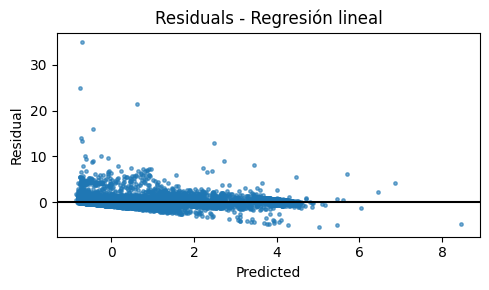

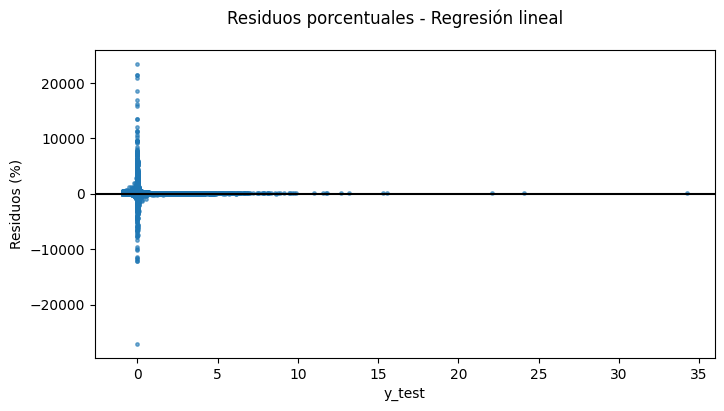

Regresión lineal -> MSE: 0.3860, R²: 0.6172


(0.3860430730205336, 0.6172002938115204)

In [296]:
resPlot(linear_model, 'Regresión lineal', x_test, y_test)


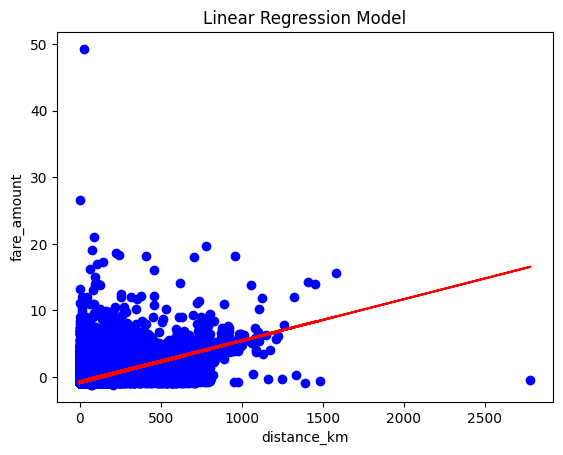

In [298]:
plt.scatter(x_train['distance_km'], y_train, color='blue')
plt.plot(x_train['distance_km'], linear_model.predict(x_train), color='red')

plt.xlabel('distance_km')
plt.ylabel('fare_amount')
plt.title('Linear Regression Model')

plt.show()

## Descenso por gradiente

In [361]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
    X_train = nxm
    y_train = nx1
    X_val = pxm
    y_val = px1
    W = (m+1)x1
    """
    # Convert pandas DataFrames to NumPy arrays
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy()


    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_val.shape[0]

    # Add bias column (ones) to the matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Initialize random weights
    W = np.random.randn(m+1, 1)  # Shape (m+1, 1)

    train_errors = []  # Store training error for each epoch
    val_errors = []    # Store validation error for each epoch

    for epoch in range(epochs):
        # Calculate training prediction and error
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calculate validation prediction and error
        prediction_val = np.matmul(X_val, W)
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)

        # Calculate gradient and update weights
        # Gradient: -2/n * X^T * (y - X*W) = -2/n * X^T * error
        gradient = -2/n * np.matmul(X_train.T, error_train)  # Shape (m+1, 1)
        W = W - (lr * gradient)

        r2_train = r2_score(y_train, prediction_train)
        r2_val = r2_score(y_val, prediction_val)

        # Optional: print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}")
            print(f"Epoch {epoch+1}/{epochs}, Train R2: {r2_train:.6f}, Val R2: {r2_val:.6f}")


    # Plot training and validation errors
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return

def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    n = X_train.shape[0]
    m = X_train.shape[1]

    # Convert pandas DataFrames to NumPy arrays
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()


    # Add bias column
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Initialize weights
    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Random permutation of the data
        permutation = np.random.permutation(n)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_train_errors = []

        for j in range(n):
            # Get single sample for SGD
            x_sample = X_train_shuffled[j].reshape(1, -1)  # Keep as row vector
            y_sample = y_train_shuffled[j].reshape(1, -1)  # Keep as column vector

            # Forward pass
            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction

            # Store training error for this sample
            sample_mse = np.mean(error ** 2)
            epoch_train_errors.append(sample_mse)

            # Calculate gradient for single sample
            gradient = -2 * np.matmul(x_sample.T, error)
            W = W - (lr * gradient)

        # Calculate average training error for this epoch
        avg_train_error = np.mean(epoch_train_errors)
        train_errors.append(avg_train_error)

        # Calculate test error for this epoch
        prediction_test = np.matmul(X_test, W)
        prediction = np.matmul(X_train, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        r2_train = r2_score(y_train, prediction)
        r2_val = r2_score(y_test, prediction_test)

        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Epoch {i+1}/{epochs}, Train MSE: {avg_train_error:.6f}, Test MSE: {test_mse:.6f}")
            print(f"Epoch {i+1}/{epochs}, Train R2: {r2_train:.6f}, Val R2: {r2_val:.6f}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return

def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=32):
    n = X_train.shape[0]
    m = X_train.shape[1]

    # Convert pandas DataFrames to NumPy arrays
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    # Add bias column
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Initialize weights
    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Random permutation of the data
        permutation = np.random.permutation(n)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_train_errors = []

        # Process mini-batches
        for j in range(0, n, batch_size):
            # Get mini-batch
            end_idx = min(j + batch_size, n)
            x_batch = X_train_shuffled[j:end_idx, :]
            y_batch = y_train_shuffled[j:end_idx].reshape(-1, 1)

            current_batch_size = end_idx - j

            # Forward pass
            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction

            # Store training error for this batch
            batch_mse = np.mean(error ** 2)
            epoch_train_errors.append(batch_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / current_batch_size
            W = W - (lr * gradient)

        avg_train_error = np.mean(epoch_train_errors)
        train_errors.append(avg_train_error)

        prediction = np.matmul(X_train, W)
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        r2_train = r2_score(y_train, prediction)
        r2_test = r2_score(y_test, prediction_test)

        if (i + 1) % 10 == 0:
            print(f"Epoch {i+1}/{epochs}, Train MSE: {avg_train_error:.6f}, Test MSE: {test_mse:.6f}")
            print(f"Epoch {i+1}/{epochs}, Train R2: {r2_train:.6f}, Val R2: {r2_test:.6f}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return

In [362]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.125, random_state=0)

In [375]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, tol=1e-6, patience=10):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().reshape(-1, 1)  # Ensure shape (n, 1)
    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy().reshape(-1, 1)

    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_val.shape[0]

    # Add bias column
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Initialize weights
    W = np.random.randn(m + 1, 1)

    train_errors = []
    val_errors = []
    train_r2_scores = []
    val_r2_scores = []
    best_val_mse = float('inf')
    best_W = W.copy()
    patience_counter = 0

    for epoch in range(epochs):
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)
        train_r2 = r2_score(y_train, prediction_train)
        train_r2_scores.append(train_r2)

        prediction_val = np.matmul(X_val, W)
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)
        val_r2 = r2_score(y_val, prediction_val)
        val_r2_scores.append(val_r2)

        # Early stopping
        if val_mse < best_val_mse - tol:
            best_val_mse = val_mse
            best_W = W.copy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            W = best_W
            break

        gradient = -2 / n * np.matmul(X_train.T, error_train)
        W = W - (lr * gradient)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}")
            print(f"Epoch {epoch + 1}/{epochs}, Train R2: {train_r2:.6f}, Val R2: {val_r2:.6f}")

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return

def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, tol=1e-6, patience=10):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().reshape(-1, 1)
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy().reshape(-1, 1)

    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_test.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))

    W = np.random.randn(m + 1, 1)
    train_errors = []
    test_errors = []
    train_r2_scores = []
    test_r2_scores = []
    best_test_mse = float('inf')
    best_W = W.copy()
    patience_counter = 0

    for i in range(epochs):
        permutation = np.random.permutation(n)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        epoch_train_errors = []

        for j in range(n):
            x_sample = X_train_shuffled[j:j+1]
            y_sample = y_train_shuffled[j:j+1]
            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            sample_mse = np.mean(error ** 2)
            epoch_train_errors.append(sample_mse)
            gradient = -2 * np.matmul(x_sample.T, error)
            W = W - (lr * gradient)

        avg_train_error = np.mean(epoch_train_errors)
        train_errors.append(avg_train_error)
        prediction_train = np.matmul(X_train, W)
        train_r2 = r2_score(y_train, prediction_train)
        train_r2_scores.append(train_r2)

        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)
        test_r2 = r2_score(y_test, prediction_test)
        test_r2_scores.append(test_r2)

        if test_mse < best_test_mse - tol:
            best_test_mse = test_mse
            best_W = W.copy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i + 1}")
            W = best_W
            break

        if (i + 1) % 10 == 0:
            print(f"Epoch {i + 1}/{epochs}, Train MSE: {avg_train_error:.6f}, Test MSE: {test_mse:.6f}")
            print(f"Epoch {i + 1}/{epochs}, Train R2: {train_r2:.6f}, Test R2: {test_r2:.6f}")

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return

def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=32, tol=1e-6, patience=10):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().reshape(-1, 1)
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy().reshape(-1, 1)

    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_test.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))

    W = np.random.randn(m + 1, 1)
    train_errors = []
    test_errors = []
    train_r2_scores = []
    test_r2_scores = []
    best_test_mse = float('inf')
    best_W = W.copy()
    patience_counter = 0

    for i in range(epochs):
        permutation = np.random.permutation(n)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        epoch_train_errors = []

        for j in range(0, n, batch_size):
            end_idx = min(j + batch_size, n)
            x_batch = X_train_shuffled[j:end_idx]
            y_batch = y_train_shuffled[j:end_idx]
            current_batch_size = end_idx - j
            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            batch_mse = np.mean(error ** 2)
            epoch_train_errors.append(batch_mse)
            gradient = -2 / current_batch_size * np.matmul(x_batch.T, error)
            W = W - (lr * gradient)

        avg_train_error = np.mean(epoch_train_errors)
        train_errors.append(avg_train_error)
        prediction_train = np.matmul(X_train, W)
        train_r2 = r2_score(y_train, prediction_train)
        train_r2_scores.append(train_r2)

        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)
        test_r2 = r2_score(y_test, prediction_test)
        test_r2_scores.append(test_r2)

        if test_mse < best_test_mse - tol:
            best_test_mse = test_mse
            best_W = W.copy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i + 1}")
            W = best_W
            break

        if (i + 1) % 10 == 0:
            print(f"Epoch {i + 1}/{epochs}, Train MSE: {avg_train_error:.6f}, Test MSE: {test_mse:.6f}")
            print(f"Epoch {i + 1}/{epochs}, Train R2: {train_r2:.6f}, Test R2: {test_r2:.6f}")

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return

A través de los distintos casos es descenso por gradiente, fuimos optimizando los hiperparámetros a mano a través de observar cómo se iba reduciendo el MSE y mejorando el $R^2$ (en cada caso)

Epoch 10/100, Train MSE: 10202.771704, Val MSE: 10292.782497
Epoch 10/100, Train R2: -10119.340191, Val R2: -10829.778415
Epoch 20/100, Train MSE: 2934.904965, Val MSE: 2959.843004
Epoch 20/100, Train R2: -2910.192913, Val R2: -3113.551748
Epoch 30/100, Train MSE: 848.538388, Val MSE: 855.244238
Epoch 30/100, Train R2: -840.682770, Val R2: -898.947205
Epoch 40/100, Train MSE: 249.610561, Val MSE: 251.322610
Epoch 40/100, Train R2: -246.593876, Val R2: -263.459052
Epoch 50/100, Train MSE: 77.677614, Val MSE: 78.084722
Epoch 50/100, Train R2: -76.050032, Val R2: -81.166151
Epoch 60/100, Train MSE: 28.320893, Val MSE: 28.422301
Epoch 60/100, Train R2: -27.092079, Val R2: -28.907914
Epoch 70/100, Train MSE: 14.151785, Val MSE: 14.202352
Epoch 70/100, Train R2: -13.037448, Val R2: -13.944699
Epoch 80/100, Train MSE: 10.083887, Val MSE: 10.139634
Epoch 80/100, Train R2: -9.002416, Val R2: -9.669625
Epoch 90/100, Train MSE: 8.915715, Val MSE: 8.983540
Epoch 90/100, Train R2: -7.843682, Val R2

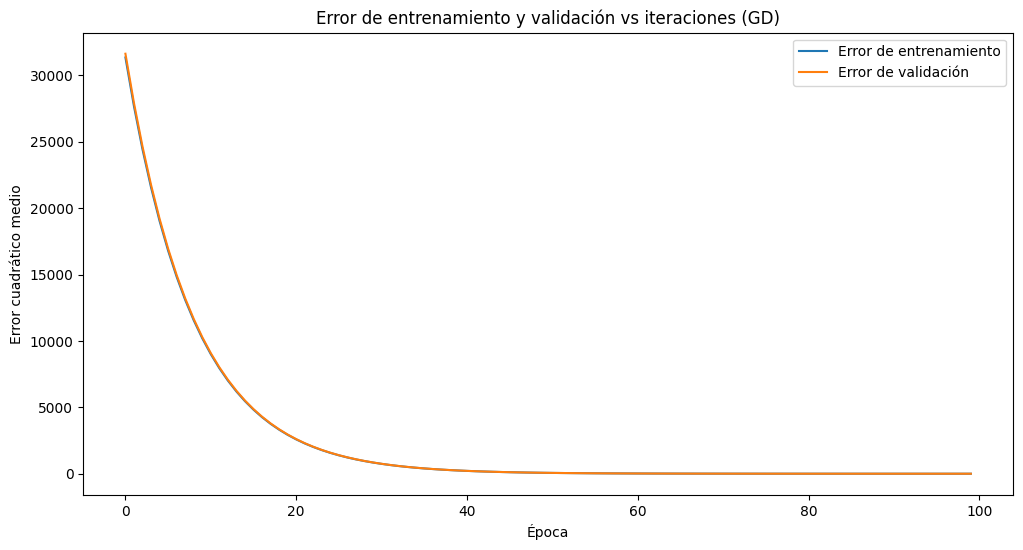

(array([[-0.3913342 ],
        [-1.36319309],
        [ 0.81658178],
        [-0.03758959],
        [ 0.39868866],
        [-0.12565735],
        [-0.45216546],
        [-1.43762332],
        [-0.82292507],
        [-1.09312057],
        [-0.90588962],
        [-0.6700543 ],
        [ 0.00290831]]),
 [np.float64(31353.799620236707),
  np.float64(27676.04922855353),
  np.float64(24429.809347747698),
  np.float64(21564.45084204502),
  np.float64(19035.284893055516),
  np.float64(16802.86602223106),
  np.float64(14832.376889710196),
  np.float64(13093.085274725225),
  np.float64(11557.864768507616),
  np.float64(10202.771704303212),
  np.float64(9006.671726196118),
  np.float64(7950.9101726189965),
  np.float64(7019.0211337718565),
  np.float64(6196.470645339007),
  np.float64(5470.430013291626),
  np.float64(4829.575734495259),
  np.float64(4263.91289263589),
  np.float64(3764.6192751051094),
  np.float64(3323.9077796538677),
  np.float64(2934.9049648759387),
  np.float64(2591.5438503652

In [379]:
# gradient_descent(x_train, y_train, x_test, y_test, lr=0.01, epochs=20)
# gradient_descent(x_train, y_train, x_test, y_test, lr=0.1, epochs=20)
# gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=50)
gradient_descent(x_train, y_train, x_test, y_test, lr=1e-6, epochs=100)

Epoch 10/50, Train MSE: 0.726494, Test MSE: 0.593180
Epoch 10/50, Train R2: 0.350858, Test R2: 0.375815
Epoch 20/50, Train MSE: 0.631644, Test MSE: 0.679807
Epoch 20/50, Train R2: 0.255168, Test R2: 0.284660
Epoch 30/50, Train MSE: 0.600743, Test MSE: 0.596943
Epoch 30/50, Train R2: 0.340406, Test R2: 0.371855
Epoch 40/50, Train MSE: 0.580650, Test MSE: 0.469593
Epoch 40/50, Train R2: 0.476147, Test R2: 0.505861
Epoch 50/50, Train MSE: 0.573764, Test MSE: 0.460414
Epoch 50/50, Train R2: 0.488260, Test R2: 0.515520


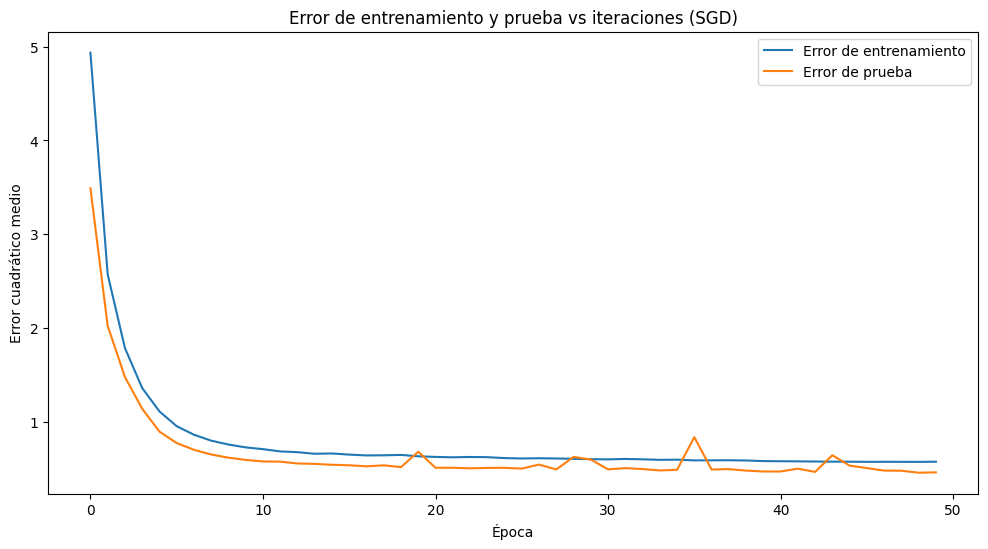

(array([[-0.73456677],
        [ 1.79729194],
        [ 1.7964092 ],
        [-0.02884833],
        [ 0.02189232],
        [ 0.00544209],
        [-0.03494456],
        [-0.11064673],
        [-0.0128354 ],
        [ 0.02043375],
        [-0.10524755],
        [ 0.03265974],
        [ 0.0061257 ]]),
 [np.float64(4.935269337547424),
  np.float64(2.571665182972836),
  np.float64(1.7859030433810192),
  np.float64(1.360015735457386),
  np.float64(1.1102126868358393),
  np.float64(0.9525324279202876),
  np.float64(0.8615945111834071),
  np.float64(0.7981531766613569),
  np.float64(0.7570639043224857),
  np.float64(0.7264941322918597),
  np.float64(0.7079699735346613),
  np.float64(0.6837146235794485),
  np.float64(0.675485566609189),
  np.float64(0.6586801038368806),
  np.float64(0.6616257701453946),
  np.float64(0.6495943751406013),
  np.float64(0.6410128815573736),
  np.float64(0.6422952292098828),
  np.float64(0.6461198696588952),
  np.float64(0.6316443986089549),
  np.float64(0.62489976

In [377]:
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.01, epochs=50)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.01, epochs=70)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.001, epochs=70)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=70)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=100)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.00001, epochs=100)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.000001, epochs=50)
stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.000001, epochs=50)


In [380]:
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.01, epochs=100, batch_size=128)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.001, epochs=20, batch_size=64)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=20, batch_size=64)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=20, batch_size=96)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=10, batch_size=128)
mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=30, batch_size=96)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.001, epochs=50, batch_size=32)


/tmp/ipykernel_64457/2013463165.py:183: RuntimeWarning: overflow encountered in square
  batch_mse = np.mean(error ** 2)
/home/jere/tuia/aa1/aa1/lib/python3.12/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_64457/2013463165.py:185: RuntimeWarning: overflow encountered in matmul
  gradient = -2 / current_batch_size * np.matmul(x_batch.T, error)
/tmp/ipykernel_64457/2013463165.py:185: RuntimeWarning: invalid value encountered in matmul
  gradient = -2 / current_batch_size * np.matmul(x_batch.T, error)
/tmp/ipykernel_64457/2013463165.py:186: RuntimeWarning: invalid value encountered in subtract
  W = W - (lr * gradient)


ValueError: Input contains NaN.

"En cada caso, podemos ver que el $R^2$ aumenta y que el error de testeo es menor al de training. A su vez, el único caso en que parece mejorar el de la regresión lineal es el de _mini batch_." Esta respuesta fue antes de correr nuevamente el código y que fallaran varias veces las funciones. Tuvimos que resolverlo rápido antes de la entrega y no pudimos obtener resultados concluyentes del descenso de gradiente.

## Regularización

Coeficientes del modelo de regresión lineal:
[[ 0.03174895  0.02994427 -0.02632136  0.0231481  -0.00638511 -0.01425722
  -0.00601978 -0.01435286 -0.00526603 -0.00823194 -0.01641276  0.00620006]]
0.6245090941799813

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00612412]
0.623065797257164

Coeficientes del modelo Ridge:
[ 0.03173826  0.02993358 -0.02632109  0.02314785 -0.00638506 -0.01425711
 -0.00601956 -0.01435175 -0.00526606 -0.00823124 -0.01641184  0.00620006]
0.6245090941748999

Coeficientes del modelo ElasticNet:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00617994]
0.623126587448953


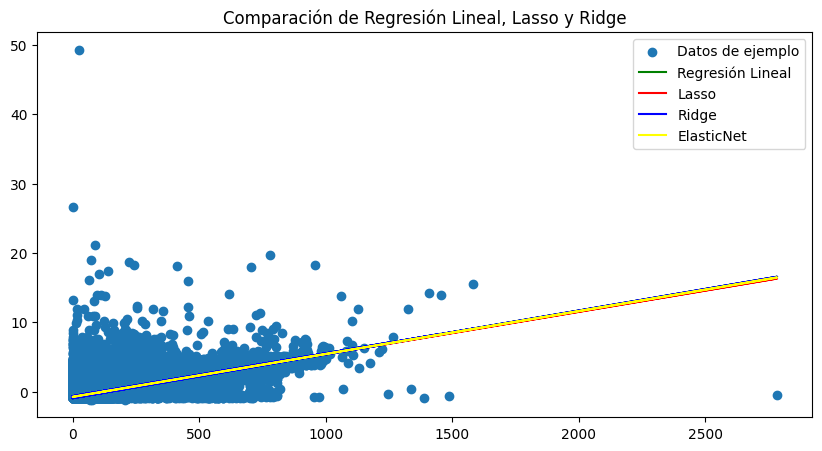

Coeficientes del modelo de regresión lineal:
[[ 0.03174895  0.02994427 -0.02632136  0.0231481  -0.00638511 -0.01425722
  -0.00601978 -0.01435286 -0.00526603 -0.00823194 -0.01641276  0.00620006]]
0.6245090941799813

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00606277]
0.6228819353544239

Coeficientes del modelo Ridge:
[ 0.03172757  0.0299229  -0.02632082  0.02314761 -0.00638501 -0.014257
 -0.00601935 -0.01435065 -0.00526609 -0.00823053 -0.01641092  0.00620006]
0.6245090941596686

Coeficientes del modelo ElasticNet:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00617441]
0.6231250961240192


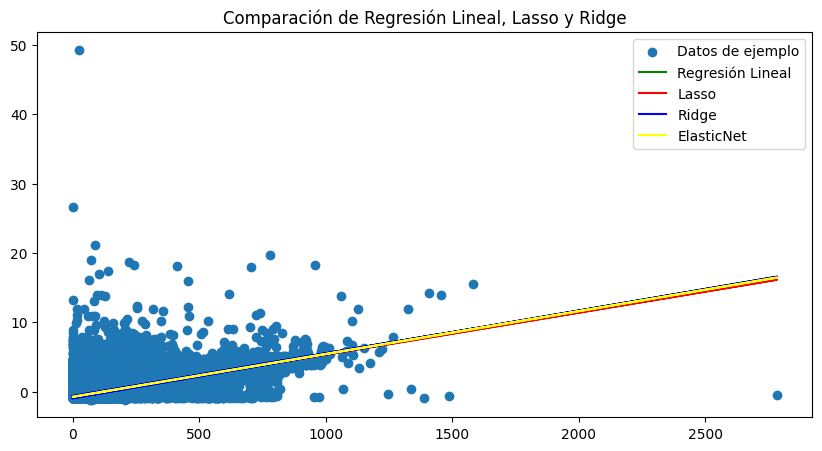

Coeficientes del modelo de regresión lineal:
[[ 0.03174895  0.02994427 -0.02632136  0.0231481  -0.00638511 -0.01425722
  -0.00601978 -0.01435286 -0.00526603 -0.00823194 -0.01641276  0.00620006]]
0.6245090941799813

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00600143]
0.6225754988498571

Coeficientes del modelo Ridge:
[ 0.03171689  0.02991223 -0.02632055  0.02314737 -0.00638495 -0.01425688
 -0.00601913 -0.01434954 -0.00526611 -0.00822983 -0.01641001  0.00620006]
0.6245090941343073

Coeficientes del modelo ElasticNet:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00616889]
0.6231226105869354


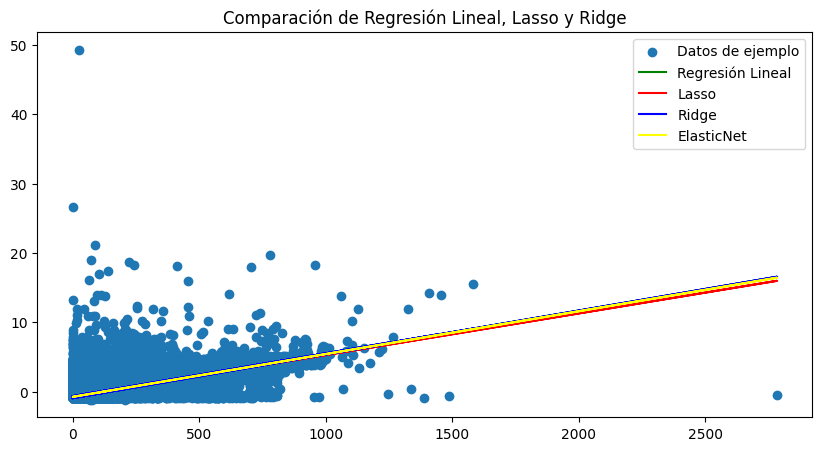

Coeficientes del modelo de regresión lineal:
[[ 0.03174895  0.02994427 -0.02632136  0.0231481  -0.00638511 -0.01425722
  -0.00601978 -0.01435286 -0.00526603 -0.00823194 -0.01641276  0.00620006]]
0.6245090941799813

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00594009]
0.6221464877434637

Coeficientes del modelo Ridge:
[ 0.03170621  0.02990156 -0.02632028  0.02314713 -0.0063849  -0.01425677
 -0.00601891 -0.01434844 -0.00526614 -0.00822912 -0.01640909  0.00620006]
0.6245090940988358

Coeficientes del modelo ElasticNet:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00616336]
0.6231191308413611


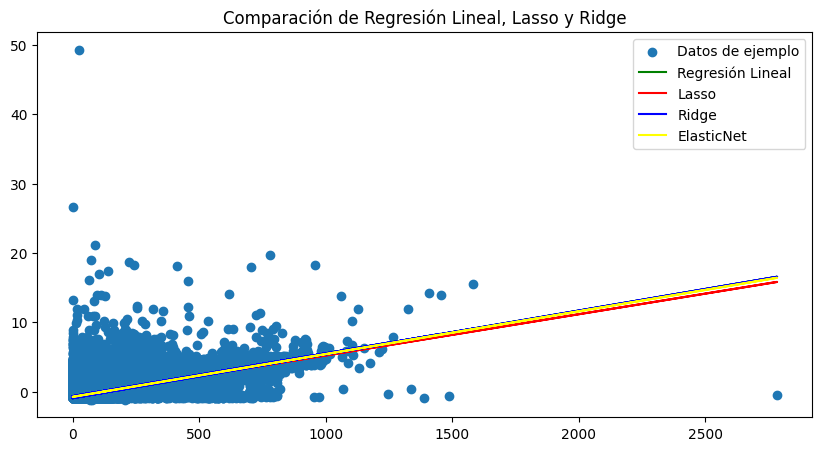

Coeficientes del modelo de regresión lineal:
[[ 0.03174895  0.02994427 -0.02632136  0.0231481  -0.00638511 -0.01425722
  -0.00601978 -0.01435286 -0.00526603 -0.00823194 -0.01641276  0.00620006]]
0.6245090941799813

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00587874]
0.6215949020352434

Coeficientes del modelo Ridge:
[ 0.03169554  0.02989091 -0.02632001  0.02314688 -0.00638485 -0.01425665
 -0.00601869 -0.01434733 -0.00526617 -0.00822842 -0.01640817  0.00620006]
0.6245090940532738

Coeficientes del modelo ElasticNet:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00615784]
0.6231146568909551


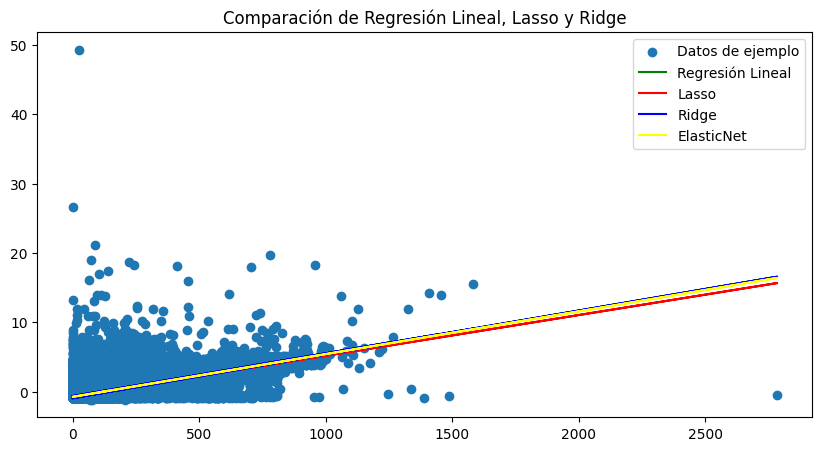

Coeficientes del modelo de regresión lineal:
[[ 0.03174895  0.02994427 -0.02632136  0.0231481  -0.00638511 -0.01425722
  -0.00601978 -0.01435286 -0.00526603 -0.00823194 -0.01641276  0.00620006]]
0.6245090941799813

Coeficientes del modelo Lasso:
[ 0.        -0.        -0.         0.        -0.        -0.
 -0.         0.        -0.         0.        -0.         0.0058174]
0.6209207417251963

Coeficientes del modelo Ridge:
[ 0.03168489  0.02988026 -0.02631975  0.02314664 -0.00638479 -0.01425654
 -0.00601847 -0.01434623 -0.00526619 -0.00822771 -0.01640725  0.00620006]
0.6245090939976408

Coeficientes del modelo ElasticNet:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00615231]
0.6231091887393772


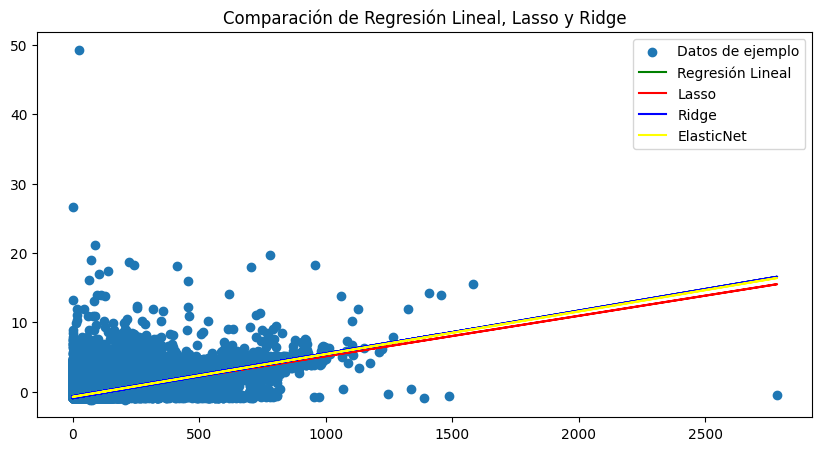

Coeficientes del modelo de regresión lineal:
[[ 0.03174895  0.02994427 -0.02632136  0.0231481  -0.00638511 -0.01425722
  -0.00601978 -0.01435286 -0.00526603 -0.00823194 -0.01641276  0.00620006]]
0.6245090941799813

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00575606]
0.6201240068133225

Coeficientes del modelo Ridge:
[ 0.03167423  0.02986961 -0.02631948  0.0231464  -0.00638474 -0.01425642
 -0.00601825 -0.01434512 -0.00526622 -0.00822701 -0.01640634  0.00620006]
0.6245090939319564

Coeficientes del modelo ElasticNet:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00614679]
0.6231027263902864


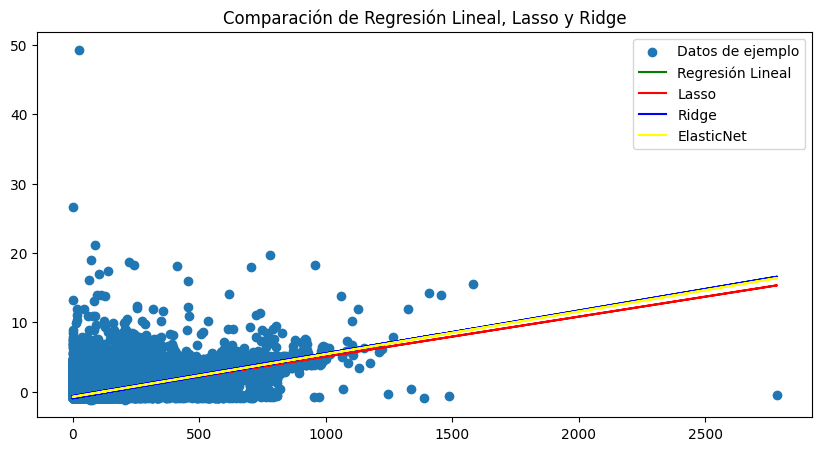

Coeficientes del modelo de regresión lineal:
[[ 0.03174895  0.02994427 -0.02632136  0.0231481  -0.00638511 -0.01425722
  -0.00601978 -0.01435286 -0.00526603 -0.00823194 -0.01641276  0.00620006]]
0.6245090941799813

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00569471]
0.619204697299622

Coeficientes del modelo Ridge:
[ 0.03166359  0.02985898 -0.02631921  0.02314616 -0.00638469 -0.01425631
 -0.00601803 -0.01434402 -0.00526625 -0.00822631 -0.01640542  0.00620006]
0.6245090938562405

Coeficientes del modelo ElasticNet:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00614126]
0.6230952698473418


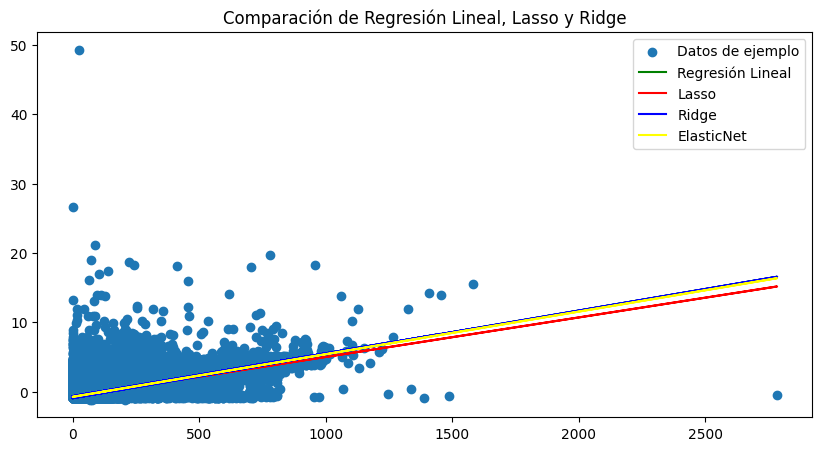

Coeficientes del modelo de regresión lineal:
[[ 0.03174895  0.02994427 -0.02632136  0.0231481  -0.00638511 -0.01425722
  -0.00601978 -0.01435286 -0.00526603 -0.00823194 -0.01641276  0.00620006]]
0.6245090941799813

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00563337]
0.6181628131840948

Coeficientes del modelo Ridge:
[ 0.03165295  0.02984835 -0.02631894  0.02314591 -0.00638464 -0.01425619
 -0.00601781 -0.01434291 -0.00526627 -0.0082256  -0.0164045   0.00620006]
0.6245090937705122

Coeficientes del modelo ElasticNet:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.00613574]
0.6230868191142029


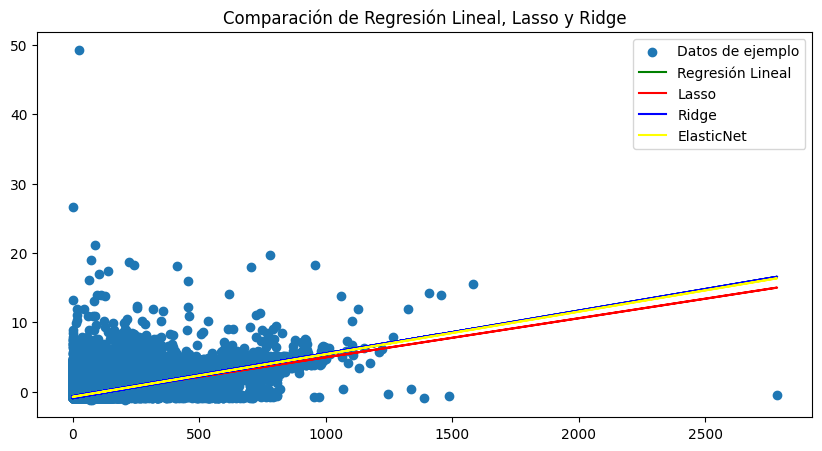

In [358]:
for i in range(1,10):
    lasso = Lasso(alpha=i)  # alpha controla la fuerza de la regularización L1 (Lasso)
    ridge = Ridge(alpha=i)  # alpha controla la fuerza de la regularización L2 (Ridge)
    elasticnet = ElasticNet(alpha=(i/10), l1_ratio=0.9)

    # Ajustar modelos a los datos
    linear_model.fit(x_train, y_train)
    lasso.fit(x_train, y_train)
    ridge.fit(x_train, y_train)
    elasticnet.fit(x_train, y_train)

    # Mostrar coeficientes
    print("Coeficientes del modelo de regresión lineal:")
    print(linear_model.coef_)
    print(linear_model.score(x_train, y_train))

    print("\nCoeficientes del modelo Lasso:")
    print(lasso.coef_)
    print(lasso.score(x_train, y_train))


    print("\nCoeficientes del modelo Ridge:")
    print(ridge.coef_)
    print(ridge.score(x_train, y_train))


    print("\nCoeficientes del modelo ElasticNet:")
    print(elasticnet.coef_)
    print(elasticnet.score(x_train, y_train))

    print("alpha = ", i)

    # Graficar resultados
    plt.figure(figsize=(10, 5))

    plt.scatter(x_train["distance_km"], y_train, label='Datos de ejemplo')
    plt.plot(x_train["distance_km"], linear_model.predict(x_train), label='Regresión Lineal', color='green')
    plt.plot(x_train["distance_km"], lasso.predict(x_train), label='Lasso', color='red')
    plt.plot(x_train["distance_km"], ridge.predict(x_train), label='Ridge', color='blue')
    plt.plot(x_train["distance_km"], elasticnet.predict(x_train), label='ElasticNet', color='purple')

    plt.legend()
    plt.title('Comparación de Regresión Lineal, Lasso y Ridge')
    plt.show()


Los coeficientes $R^2$ resultan similares entre sí, mientras que Lasso se va corriendo a medida que se aumenta el valor de alpha

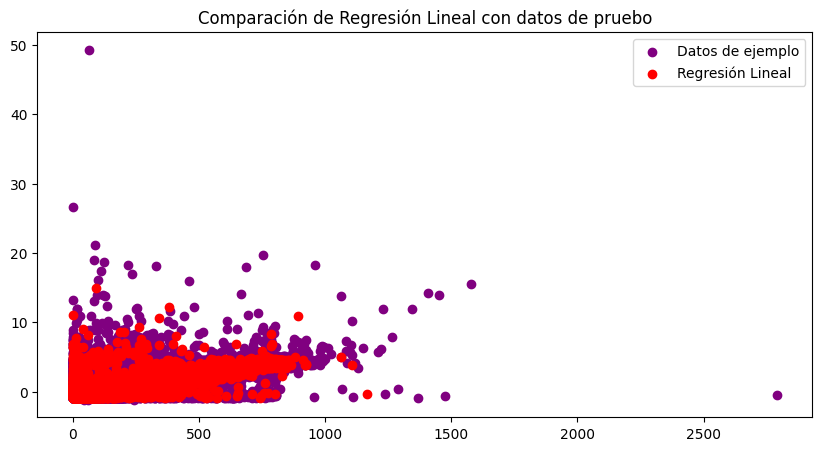

In [248]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train["distance_km"], y_train, label='Datos de ejemplo', color='purple')
plt.scatter(x_test["distance_km"], y_test, label='Regresión Lineal', color='red')
plt.legend()
plt.title('Comparación de Regresión Lineal con datos de pruebo')
plt.show()

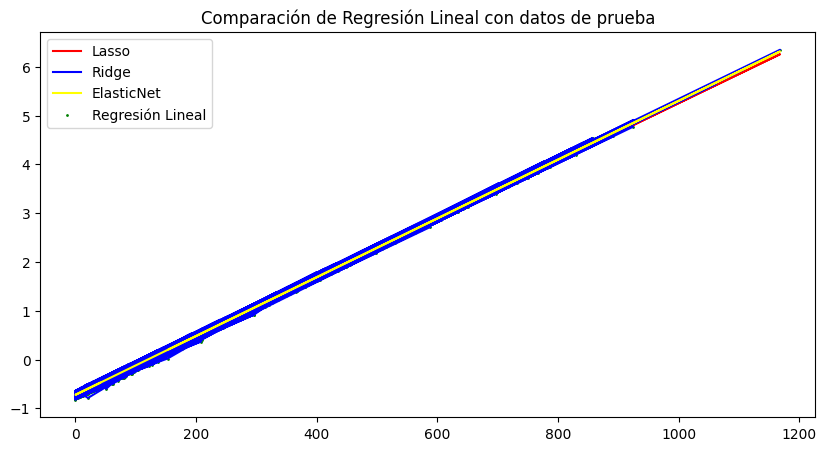

In [264]:
# Ordenamos x_test por distance_km
    
plt.figure(figsize=(10, 5))
plt.plot(x_test["distance_km"], lasso.predict(x_test), label='Lasso', color='red')
plt.plot(x_test["distance_km"], ridge.predict(x_test), label='Ridge', color='blue')
plt.plot(x_test["distance_km"], elasticnet.predict(x_test), label='ElasticNet', color='yellow')
plt.scatter(x_test["distance_km"], linear_model.predict(x_test), label='Regresión Lineal', color='green', s=1)

plt.legend()
plt.title('Comparación de Regresión Lineal con datos de prueba')
plt.show()


En los 3 casos (Lasso, Ridge y ElasticNet) se obtuvieron rectas que coinciden con la regresión lineal

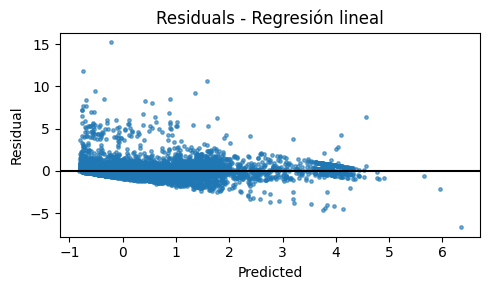

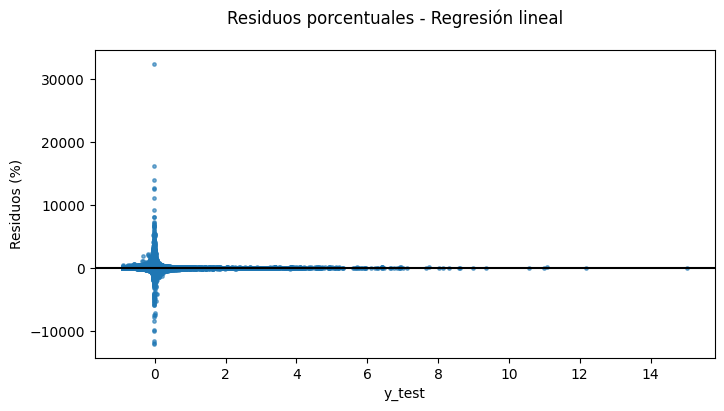

Regresión lineal -> MSE: 0.3783, R²: 0.6126


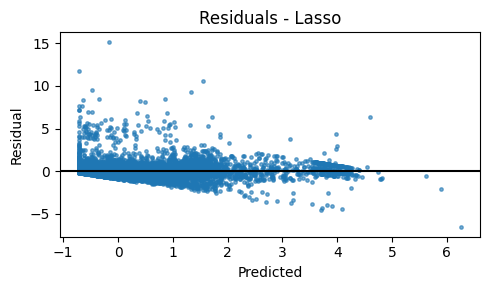

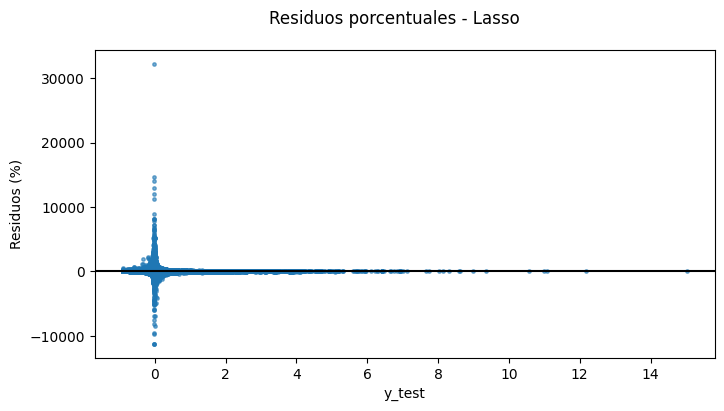

Lasso -> MSE: 0.3791, R²: 0.6118


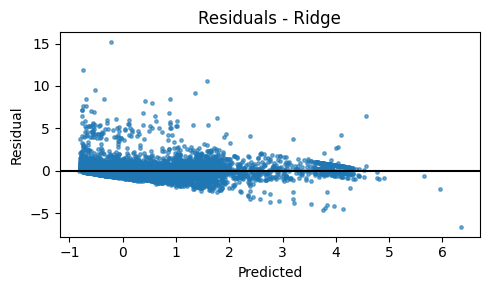

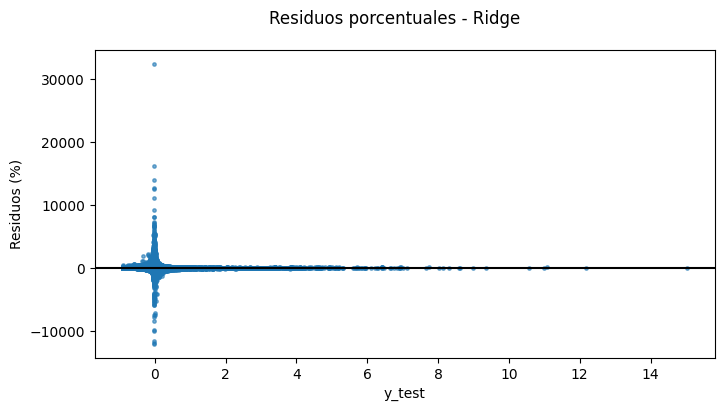

Ridge -> MSE: 0.3783, R²: 0.6126


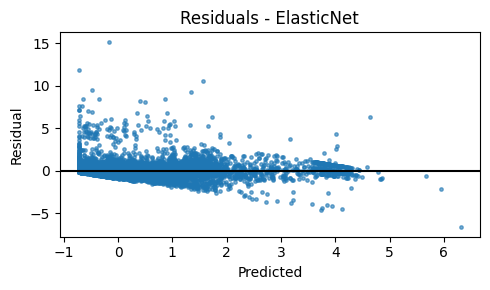

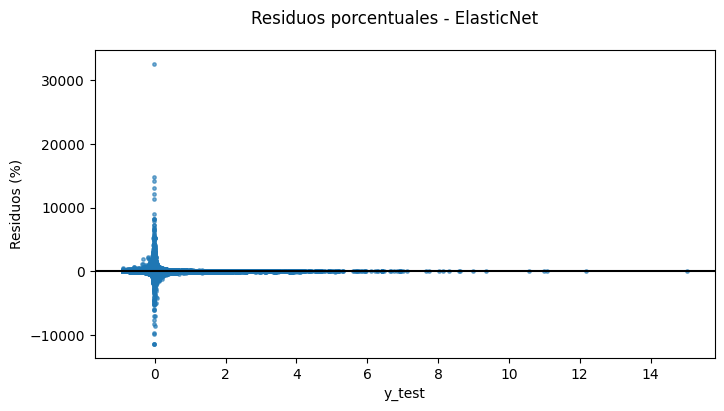

ElasticNet -> MSE: 0.3791, R²: 0.6118


(0.37911224173617203, 0.6118135013431139)

In [270]:

resPlot(linear_model, 'Regresión lineal', x_test, y_test)
resPlot(lasso, 'Lasso', x_test, y_test)
resPlot(ridge, 'Ridge', x_test, y_test)
resPlot(elasticnet, 'ElasticNet', x_test, y_test)


# Conclusiones

Los resultados muestran un $R^2$ cercano a $0.6$ ($60\%$ de la variabilidad explicada), con un MSE de aproximadamente $0.4$. Los valores de training y test son semejantes entre sí en la regresión lineal. Si bien teóricamente indica un modelo bien balanceado sin overfitting, pero consideramos que es necesario profundizar en la imputación de datos faltantes para las variables geográficas. A su vez, nos hubiera gustado explorar un poco cómo varía el modelo con una mejor imputación y tratamiento de overfitting, como por ejemplo, considerar outlier a los valores de que se alejen a un cierto valor del rango intercuartílico.

No pudimos realizar correctamente ni concluir el descenso por gradiente. Esto será corregido para la segunda parte de la materia.

Respecto a la regularización, vemos Lasso se aleja del modelo lineal a medida que hacemos crecer el alpha, mientras que Ridge casi no ve diferencia con nuestro modelo, indicando coeficientes ya balanceados. Lasso se aleja progresivamente con mayor alpha, revelando variables de diferente importancia y permitiendo selección automática de características.